In [1]:
import h5py
import numpy as np

In [2]:
class IncrementalStats:
    def __init__(self):
        # Initialize counters for the number of samples, mean, and variance
        self.N = 0  # Total number of samples processed
        self.mean = 0  # Current mean
        self.variance = 0  # Current variance
    
    def update(self, new_data):
        # Calculate batch size, mean, and variance of the new data batch
        new_N = len(new_data)
        new_mean = np.mean(new_data)
        new_variance = np.var(new_data)
        
        # Update the total number of samples
        total_N = self.N + new_N
        
        # Update the mean incrementally
        updated_mean = (self.N * self.mean + new_N * new_mean) / total_N
        
        # Update the variance incrementally
        if self.N > 0:
            updated_variance = (
                (self.N * self.variance + new_N * new_variance) / total_N
                + (self.N * new_N * (self.mean - new_mean) ** 2) / (total_N ** 2)
            )
        else:
            updated_variance = new_variance  # For the first batch
        
        # Update the internal state
        self.N = total_N
        self.mean = updated_mean
        self.variance = updated_variance
    
    def get_mean(self):
        return self.mean
    
    def get_std(self):
        return np.sqrt(self.variance)

# Example usage
incremental_stats = IncrementalStats()

# Simulating batch updates
batch_1 = np.array([1.0, 2.0, 3.0])
incremental_stats.update(batch_1)

batch_2 = np.array([4.0, 5.0])
incremental_stats.update(batch_2)

print(f"Incremental mean: {incremental_stats.get_mean()}")
print(f"Incremental standard deviation: {incremental_stats.get_std()}")

Incremental mean: 3.0
Incremental standard deviation: 1.4142135623730951


## different activities need different means and standard deviations

In [15]:
import h5py
import numpy as np

class IncrementalStats:
    def __init__(self):
        self.N = 0
        self.mean = None
        self.variance = None
    
    def update(self, new_data):
        new_N = new_data.shape[0]
        new_mean = np.mean(new_data, axis=0)
        new_variance = np.var(new_data, axis=0)
        
        if self.mean is None:
            self.mean = new_mean
            self.variance = new_variance
            self.N = new_N
        else:
            total_N = self.N + new_N
            updated_mean = (self.N * self.mean + new_N * new_mean) / total_N
            updated_variance = (
                (self.N * self.variance + new_N * new_variance) / total_N
                + (self.N * new_N * (self.mean - new_mean) ** 2) / (total_N ** 2)
            )
            self.N = total_N
            self.mean = updated_mean
            self.variance = updated_variance

    def get_mean(self):
        return self.mean
    
    def get_std(self):
        return np.sqrt(self.variance)


# Initialize the parameter dictionary
activity_para_dict = {}

# File paths and dataset
uschad_data_path = './Datas/USC_HAD_dataset.h5'
train_list = [1,2,3,4,5,6,7,8,9]

# Open the dataset
with h5py.File(uschad_data_path, 'r') as f_r:
    data_grp = f_r['datas']
    
    # Loop through the dataset keys
    for key in data_grp:
        # Extract subject and activity indices
        subject_i = int(key.split('_')[0].split('b')[1])
        activity_i = key.split('_')[1].split('a')[1]
        
        # Skip if the subject is not in the train list
        if subject_i not in train_list:
            continue

        # Load the data for this trial
        trial_data = np.array(data_grp[key])
        
        # Initialize IncrementalStats for each activity if not already in the dictionary
        if activity_i not in activity_para_dict:
            activity_para_dict[activity_i] = IncrementalStats()

        # Update the stats for the current activity
        activity_para_dict[activity_i].update(trial_data)

# Save the mean and std of each activity to an HDF5 file
output_h5py_path = './Datas/uschad_activity_parameters.h5'
with h5py.File(output_h5py_path, 'w') as f_w:
    for activity, stats in activity_para_dict.items():
        mean = stats.get_mean()
        std = stats.get_std()
        
        # Save the mean and std for this activity in the HDF5 file
        f_w.create_dataset(f'{activity}/mean', data=mean)
        f_w.create_dataset(f'{activity}/std', data=std)

        # Print for checking
        print(f'Activity {activity}: Mean shape: {mean}, Std shape: {std}')


# Applying the calculated parameters during data processing
def apply_normalization(data, activity, activity_para_dict):
    """Applies the mean and std normalization for the given activity."""
    mean = activity_para_dict[activity].get_mean()
    std = activity_para_dict[activity].get_std()
    
    # Normalize the data
    return (data - mean) / (std + 1e-8)  # Adding a small constant to avoid division by zero


# Example usage: Load a test trial and normalize based on the activity mean/std
with h5py.File(uschad_data_path, 'r') as f_r:
    test_trial = f_r['datas']['sub12_a3_trial1']  # Example trial
    activity = '3'  # Activity index
    normalized_data_test = apply_normalization(test_trial, activity, activity_para_dict)
    
    train_trial = f_r['datas']['sub1_a3_trial1']
    normalized_data_train = apply_normalization(train_trial, activity, activity_para_dict)
    print('check min and max on train', np.min(normalized_data_train, 0), np.max(normalized_data_train, 0))
    print('check min and max on test', np.min(normalized_data_test, 0), np.max(normalized_data_train, 0))
    # print(f'Normalized data for sub12_a3_trial1: {normalized_data.shape}')


Activity 10: Mean shape: [-0.5196329   0.59401958 -0.22174934 -0.00406078  0.00223029  0.00841752], Std shape: [0.3715384  0.41490181 0.32319146 2.10898974 1.41954232 2.32720041]
Activity 11: Mean shape: [ 0.9270141   0.34147598 -0.10944372 -0.08597624 -0.04979096  0.04334709], Std shape: [0.04349677 0.09340629 0.11440484 4.59843404 3.82722627 2.1982048 ]
Activity 12: Mean shape: [ 0.92741534  0.34003236 -0.10705996 -0.04559116 -0.07663385  0.08755785], Std shape: [0.0461052  0.10065777 0.11683802 5.97485646 4.23458415 3.08973422]
Activity 1: Mean shape: [ 0.97165233  0.01000013 -0.10431792  0.74628317 -1.0839197   0.34396076], Std shape: [ 0.35685347  0.26722338  0.26153283 51.88362265 28.15745122 42.62614971]
Activity 2: Mean shape: [ 0.97072791  0.02765025 -0.08869843 24.64892371  1.93437172 -2.40588278], Std shape: [ 0.36652257  0.27274009  0.2746495  56.84935069 27.49659484 43.16565851]
Activity 3: Mean shape: [  0.968976     0.04728519  -0.08474551 -24.93846565  -1.74471529
  -0.

In [10]:
mean_ = np.mean(randn_data, axis=0)
print(mean_.shape)

(6,)


In [2]:
import os
uschad_data_timediff = '../master_prediction_v7.0 simplified/datasets/uschad_metrix.h5'
os.path.exists(uschad_data_timediff)

True

In [10]:
with h5py.File(uschad_data_timediff, 'r') as f_r:
    data_grp = f_r['datas']
    trainset = data_grp['train'][:]
    testset = data_grp['test'][:]
print(testset.shape)

(21014, 368, 6)


In [5]:
import matplotlib.pyplot as plt

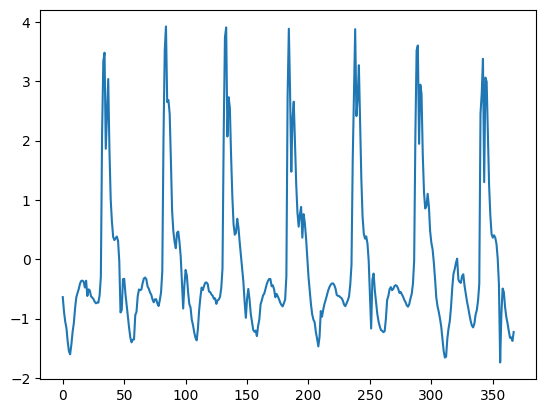

In [19]:
plt.plot(testset[5999,:,0])

In [20]:
def load_activity_parameters(h5py_path):
    """Loads the mean and std for each activity from the HDF5 file."""
    activity_para_dict = {}

    with h5py.File(h5py_path, 'r') as f_r:
        for activity in f_r.keys():
            mean = np.array(f_r[f'{activity}/mean'])
            std = np.array(f_r[f'{activity}/std'])
            activity_para_dict[activity] = {'mean': mean, 'std': std}

    return activity_para_dict 

uschad_para_path = './Datas/uschad_activity_parameters.h5'
activity_para_dict = load_activity_parameters(uschad_para_path)

# Separate different activities, save original datasets

In [3]:
import h5py
from sklearn.preprocessing import StandardScaler

uschad_data_path = './Datas/uschad_dataset.h5'
uschad_activity_path = './Datas/uschad_activity_dataset.h5'

activity_name_dict = {
    1: "walkingforward",
    2: "walkingleft",
    3: "walkingright",
    4: "walkingupstairs",
    5: "walkingdownstairs",
    6: "runningforward",
    7: "jumping",
    8: "sitting",
    9: "standing",
    10: "sleeping",
    11: "elevatorup",
    12: "elevatordown"
}

def sliding_window(dataset, window_size, step_size):
    data_len = dataset.shape[0]
    num_windows = (data_len - window_size) // step_size + 1
    windows = []
    for i in range(num_windows):
        start_idx = i * step_size
        windows.append(dataset[start_idx : start_idx + window_size, :])
    return np.array(windows)

activity_data_dict = {}
scaler = StandardScaler()
with h5py.File(uschad_data_path, 'r') as f_r:
    data_grp = f_r['datas']
    for key in data_grp:
        
        key_data = data_grp[key][:]
        
        activity_i = key.split('_')[1].split('a')[1]
        activity_name = activity_name_dict[int(activity_i)]
        if activity_name not in activity_data_dict:
            activity_data_dict[activity_name] = []
        
        # slide_key_data = sliding_window(key_data, 128, 12)
        # activity_data_dict[activity_name].append(slide_key_data)
        key_data = scaler.fit_transform(key_data)
        activity_data_dict[activity_name].append(key_data)
        
with h5py.File(uschad_activity_path, 'w') as f_w:
    data_grp = f_w.create_group(name='datas')
    
    for key in activity_data_dict:
        aggregated_data = np.concatenate(activity_data_dict[key])
        
        data_grp.create_dataset(name=key, data=aggregated_data)
        
        print('check shape', key, aggregated_data.shape[0])
        

            
        
        
        
    

check shape sleeping 375000
check shape elevatorup 165491
check shape elevatordown 164999
check shape walkingforward 381400
check shape walkingleft 258800
check shape walkingright 275500
check shape walkingupstairs 211800
check shape walkingdownstairs 197400
check shape runningforward 176500
check shape jumping 107100
check shape sitting 261500
check shape standing 236000


In [12]:
for key in activity_data_dict:
    aggregated_data = np.concatenate(activity_data_dict[key])
    print('check shape', key, aggregated_data.shape)

check shape sleeping (375000, 6)
check shape elevator up (165491, 6)
check shape elevator down (164999, 6)
check shape walkingforward (381400, 6)
check shape walkingleft (258800, 6)
check shape walkingright (275500, 6)
check shape walkingupstairs (211800, 6)
check shape walkingdownstairs (197400, 6)
check shape runningforward (176500, 6)
check shape jumping (107100, 6)
check shape sitting (261500, 6)
check shape standing (236000, 6)


In [2]:
import os, re


def find_recent_pth(folder_path):
    # List all files in the directory
    files = os.listdir(folder_path)
    
    # Filter out .pt files
    pt_files = [f for f in files if f.endswith('.pt')]
    
    # If no .pt files found, return None
    if not pt_files:
        return None

    # Extract the episode number from the filename using regular expressions
    def extract_episode_number(filename):
        match = re.search(r'ep(\d+)', filename)
        if match:
            return int(match.group(1))
        return -1
    
    # Sort the files by the extracted episode number
    pt_files.sort(key=extract_episode_number, reverse=True)

    # Return the latest .pt file (the first one after sorting)
    return pt_files[0]

folder_path = './Experiments/jumping/'
file_path = find_recent_pth(folder_path)
print(file_path)

jumping_ep49.pt


In [3]:
file_part = file_path.split('.')[0].split('ep')[1]
print(file_part)

49


In [11]:
import h5py

metrix_path = '/mnt/data728/datasets/USC-HAD-maodong/uschad_metrix_generate.h5'
with h5py.File(metrix_path, 'r') as f_r:
    data_grp = f_r['train_datas']
    dataset = data_grp['0']
    print(dataset.shape)
    print(dataset.attrs['activity'])


(200, 6)
9


In [14]:
dataset_path = './Datas/uschad_activity_dataset.h5'
with h5py.File(dataset_path, 'r') as f_r:
    data_grp = f_r['datas']
    jumping_dataset = data_grp['jumping']
    print(jumping_dataset.shape)

(107100, 6)


In [5]:
activity_name_dict = {
    1: "walkingforward",
    2: "walkingleft",
    3: "walkingright",
    4: "walkingupstairs",
    5: "walkingdownstairs",
    6: "runningforward",
    7: "jumping",
    8: "sitting",
    9: "standing",
    10: "sleeping",
    11: "elevatorup",
    12: "elevatordown"
}

activity_label = {
    'walkingforward': 1,
    'walkingleft': 2,
    'walkingright': 3,
    'walkingupstairs': 4,
    'walkingdownstairs': 5,
    'runningforward': 6,
    'jumping': 7,
    'sitting': 8,
    'standing': 9,
    'sleeping': 10,
    'elevatorup': 11,
    'elevatordown': 12
}


In [16]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pdb

dataset_path = './Datas/uschad_activity_dataset.h5'
output_path = './Datas/genbylabel_dataset.h5'

window = 24  # Size of each split window

# Create a new HDF5 file to store splitted datasets
with h5py.File(dataset_path, 'r') as f_r, h5py.File(output_path, 'w') as f_w:
    datagrp = f_r['datas']
    label_all = []
    data_all = []
    
    for activity_name, dataset in datagrp.items():
        data = dataset[:]
        scaler = MinMaxScaler()
        data_fitted = scaler.fit_transform(data)
        
        num_splits = max((data.shape[0] - window + 1) // window, 0)
        
        for i in range(num_splits):
            start = i * window
            end = (i + 1) * window
            data_all.append(data_fitted[start:end, :])
            label_all.append(activity_label[activity_name]-1)
        
    f_w.create_dataset(name='datas', data=np.array(data_all))
    f_w.create_dataset(name='labels', data=np.array(label_all, dtype='int'))
    

In [32]:
with h5py.File(output_path, 'r') as f_r:
    datagrp = f_r['datas'][:]
    print(datagrp.shape)
    labelgrp = f_r['labels'][:]
    print(labelgrp.shape)

datagrp[100,:,4]

(117141, 24, 6)
(117141,)


array([0.81693952, 0.82459338, 0.81700041, 0.81704233, 0.81708413,
       0.81712581, 0.81716738, 0.81720883, 0.81725016, 0.81729137,
       0.80972074, 0.81739666, 0.81743745, 0.80986642, 0.81754192,
       0.8099706 , 0.81764579, 0.82529756, 0.81770259, 0.81774251,
       0.81778232, 0.81782201, 0.81024993, 0.82553598])

In [17]:
import numpy as np
import h5py

dataset_path = './Datas/uschad_activity_dataset.h5'
output_path = './Datas/genbylabel_dataset.h5'

window = 24  # Size of each split window

# Create a new HDF5 file to store splitted datasets
with h5py.File(output_path, 'r') as f_r, h5py.File(dataset_path, 'a') as f_w:

    data_all = f_r['datas'][:]
    label_all = f_r['labels'][:]
    
    if 'data_genbylabel' in f_w:
        del f_w['data_genbylabel']
    if 'label_genbylabel' in f_w:
        del f_w['label_genbylabel']
    
    f_w.create_dataset(name='data_genbylabel', data=data_all)
    f_w.create_dataset(name='label_genbylabel', data=label_all)
    

In [18]:
import h5py
dataset_path = './Datas/uschad_activity_dataset.h5'
with h5py.File(dataset_path, 'r') as f_r:
    datagrp = f_r['datas']
    jumping  = datagrp['jumping']
    length = (jumping.shape[0] - 24+1) // 24 
    
    label_genbylabel = f_r['label_genbylabel'][:]
    jumping_count = np.sum(label_genbylabel == 6)
    
    print(jumping.shape, length, jumping_count)

(107100, 6) 4461 4461


In [15]:
(164999 - 23)  // 24

6874